In [1]:
import numpy as np

import pandas as pd

import scipy
import scipy.sparse as sp

import tensorflow as tf

class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

#Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [2]:

df = pd.read_csv("isoform_merged_utr3_only_iso_nonlead_sizematched_SNPs.csv", sep='\t')


In [3]:

df


,Unnamed: 0,Unnamed: 0.1,chrom,start,end,gene,gene_id,strand,chr_2,snp_pos,...,mean_PDUI,snp_transcript_id,qtl_cut_pos,snp_distance,row_id,abs_effect_size,tissue_type,extended_snp_id,effect_size_median,n_tissues
0,0,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,0.019006,chr13_76099804_T_A_NM_203497,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.001369,Adipose_Subcutaneous,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6
1,1,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,0.019630,chr13_76099804_T_A_NM_203497,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.001919,Artery_Aorta,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6
2,2,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,0.017935,chr13_76099804_T_A_NM_203497,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.001592,Esophagus_Mucosa,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6
3,3,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,0.018150,chr13_76099804_T_A_NM_203497,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.002479,Skin_Not_Sun_Exposed_Suprapubic,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6
4,4,9,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,0.022173,chr13_76099804_T_A_NM_203497,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.001648,Thyroid,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32873,32873,28,chr13,99104969,99105429,STK24,STK24.12,-,chr13,99105302,...,0.030684,chr13_99105302_G_A_NM_001032296,99097439,7863,STK24.12_chr13_99105302_G_A_NM_001032296,0.002951,Whole_Blood,chr13_99105302_G_A__STK24.12__NM_001032296,-0.002951,1
32874,32874,29,chr13,99104827,99105429,STK24,STK24.10,-,chr13,99105302,...,0.030684,chr13_99105302_G_A_NM_001032296,99097439,7863,STK24.10_chr13_99105302_G_A_NM_001032296,0.002951,Whole_Blood,chr13_99105302_G_A__STK24.10__NM_001032296,-0.002951,1
32875,32875,30,chr13,99102456,99105429,STK24,STK24.2,-,chr13,99102607,...,0.030684,chr13_99102607_C_T_NM_001032296,99097439,5168,STK24.2_chr13_99102607_C_T_NM_001032296,0.002960,Whole_Blood,chr13_99102607_C_T__STK24.2__NM_001032296,-0.002960,1
32876,32876,38,chr13,99103600,99105429,STK24,STK24.3,-,chr13,99104004,...,0.030684,chr13_99104004_T_C_NM_001032296,99097439,6565,STK24.3_chr13_99104004_T_C_NM_001032296,0.003131,Whole_Blood,chr13_99104004_T_C__STK24.3__NM_001032296,-0.003131,1


In [4]:
#From Sabeti_testSet/pmirGLO_construct.txt

utr5 = "GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCGGCCAATAGCAGCTTTGCTCCTTCGCTTTCTGGGCTCAGAGGCTGGGAAGGGGTGGGTCCGGGGGCGGGCTCAGGGGCGGGCTCAGGGGCGGGGCGGGCGCCCGAAGGTCCTCCGGAGGCCCGGCATTCTGCACGCTTCAAAAGCGCACGTCTGCCGCGCTGTTCTCCTCTTCCTCATCTCCGGGCCTTTCGACCTGCAGCCCAAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACC"
orf = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCTTCACCTACGGCGTGCAGTGCTTCGCCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAAGGTCTATATCACCGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGACCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAA"

print("len(utr5) = " + str(len(utr5)))
print("len(orf) = " + str(len(orf)))

df['full_seq_ref'] = utr5 + orf + df['seq'].str.slice(3)
df['full_seq_var'] = utr5 + orf + df['seq_var'].str.slice(3)


len(utr5) = 283
len(orf) = 720


In [5]:
df

,Unnamed: 0,Unnamed: 0.1,chrom,start,end,gene,gene_id,strand,chr_2,snp_pos,...,qtl_cut_pos,snp_distance,row_id,abs_effect_size,tissue_type,extended_snp_id,effect_size_median,n_tissues,full_seq_ref,full_seq_var
0,0,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.001369,Adipose_Subcutaneous,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
1,1,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.001919,Artery_Aorta,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
2,2,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.001592,Esophagus_Mucosa,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
3,3,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.002479,Skin_Not_Sun_Exposed_Suprapubic,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
4,4,9,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,76099350,454,COMMD6.1_chr13_76099804_T_A_NM_203497,0.001648,Thyroid,chr13_76099804_T_A__COMMD6.1__NM_203497,0.001783,6,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32873,32873,28,chr13,99104969,99105429,STK24,STK24.12,-,chr13,99105302,...,99097439,7863,STK24.12_chr13_99105302_G_A_NM_001032296,0.002951,Whole_Blood,chr13_99105302_G_A__STK24.12__NM_001032296,-0.002951,1,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
32874,32874,29,chr13,99104827,99105429,STK24,STK24.10,-,chr13,99105302,...,99097439,7863,STK24.10_chr13_99105302_G_A_NM_001032296,0.002951,Whole_Blood,chr13_99105302_G_A__STK24.10__NM_001032296,-0.002951,1,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
32875,32875,30,chr13,99102456,99105429,STK24,STK24.2,-,chr13,99102607,...,99097439,5168,STK24.2_chr13_99102607_C_T_NM_001032296,0.002960,Whole_Blood,chr13_99102607_C_T__STK24.2__NM_001032296,-0.002960,1,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
32876,32876,38,chr13,99103600,99105429,STK24,STK24.3,-,chr13,99104004,...,99097439,6565,STK24.3_chr13_99104004_T_C_NM_001032296,0.003131,Whole_Blood,chr13_99104004_T_C__STK24.3__NM_001032296,-0.003131,1,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...


In [15]:

#!wget https://zenodo.org/record/6326409/files/datasets.zip?download=1


--2022-04-02 22:38:48--  https://zenodo.org/record/6326409/files/datasets.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18751132386 (17G) [application/octet-stream]
Saving to: ‘datasets.zip?download=1’

datasets.zip?downlo 100%[===================>]  17.46G  7.88MB/s    in 30m 35s 

2022-04-02 23:09:25 (9.74 MB/s) - ‘datasets.zip?download=1’ saved [18751132386/18751132386]



In [11]:

#!unzip ./datasets.zip "datasets/deeplearning/train_gru/params.json" -d "./"
'''
for f in range(10) :
    for c in range(5) :
        !unzip ./datasets.zip "datasets/deeplearning/train_gru/f{f}_c{c}/train/model0_best.h5" -d "./"
'''

Archive:  ./datasets.zip
  inflating: ./datasets/deeplearning/train_gru/params.json  


'\nfor f in range(10) :\n    for c in range(5) :\n        !unzip ./datasets.zip "datasets/deeplearning/train_gru/f{f}_c{c}/train/model0_best.h5" -d "./"\n'

In [6]:
import os, sys
import argparse, json, h5py, time

from basenji import dna_io

try:
    import rnann
except:
    from basenji import rnann

encode_batch_size = 4800
predict_batch_size = 64
MAXLEN = 12288

params_file = "datasets/deeplearning/train_gru/params.json"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_model = params['model']
params_train = params['train']

aa_len = int(len(orf)/3)
coding = np.append(np.zeros(len(utr5)), np.tile([1,0,0], aa_len))

seqs = df['full_seq_ref'].values.tolist()

batch_remainder = (encode_batch_size - len(seqs) % encode_batch_size) if len(seqs) % encode_batch_size > 0 else 0

seqs.extend([df.iloc[-1]['full_seq_ref'] for i in range(batch_remainder)])

n_batches = len(seqs) // encode_batch_size

print("n_batches = " + str(n_batches))

#One-hot encode and predict mini-batches

for f in range(10) :
    for c in range(5) :

        print('f' + str(f) + '_c' + str(c))
        
        model_file = "datasets/deeplearning/train_gru/f" + str(f) + "_c" + str(c) + "/train/model0_best.h5"

        # initialize model
        seqnn_model = rnann.RnaNN(params_model)
        seqnn_model.restore(model_file)
        
        seqnn_model = tf.keras.models.Model(
            seqnn_model.model.inputs,
            seqnn_model.model.layers[-5].output
            #seqnn_model.model.layers[-2].output
        )

        seqnn_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(0.1))
        
        preds = []
        for batch_ix in range(n_batches) :

            if batch_ix % 1 == 0 : 
                print("batch_ix = " + str(batch_ix))

            batch = np.zeros((encode_batch_size,MAXLEN,6))

            for i, myseq in enumerate(seqs[batch_ix*encode_batch_size:(batch_ix+1)*encode_batch_size]) :
                batch[i,0:len(myseq),0:4] = dna_io.dna_1hot(myseq)
                batch[i,0:len(coding),4] = coding

            pred = seqnn_model.predict(batch, batch_size=predict_batch_size)

            preds.append(pred)

        preds = np.concatenate(preds, axis=0)[:len(df), :]

        for feature_ix in range(preds.shape[1]) :
            df['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_ref'] = preds[:, feature_ix]


n_batches = 7
f0_c0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift (Stochastic (None, 12288, 6)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization (LayerNo (None, 12284, 64)         128       
_________________________________________________________________
re_lu (ReLU)                 (None, 12284, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12280, 64)         20544     
_________________________________________________________________
dropout (Dropout)            (None, 12280

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f0_c2
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_2 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_14 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 12280, 64)         20544     
_________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f0_c4
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_4 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_28 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_36 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f1_c1
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_6 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_42 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_54 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f1_c3
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_8 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_56 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_72 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f2_c0
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_10 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_70 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_90 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f2_c2
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_12 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_84 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_108 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f2_c4
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_14 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_98 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_126 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f3_c1
Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_16 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_112 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_144 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f3_c3
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_18 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_126 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_162 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f4_c0
Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_20 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_140 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_180 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f4_c2
Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_22 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_154 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_198 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f4_c4
Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_24 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_168 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_216 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f5_c1
Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_26 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_182 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_234 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f5_c3
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_28 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_196 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_252 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f6_c0
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_30 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_210 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_210 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_270 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_211 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f6_c2
Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_32 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_224 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_224 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_288 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 12280, 64)         20544     
________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f6_c4
Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_34 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_238 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_238 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_306 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f7_c1
Model: "model_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_36 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_252 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_252 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_324 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f7_c3
Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_38 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_266 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_266 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_342 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f8_c0
Model: "model_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_40 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_280 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_280 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_360 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f8_c2
Model: "model_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_42 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_294 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_294 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_378 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_295 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f8_c4
Model: "model_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_44 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_308 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_308 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_396 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f9_c1
Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_46 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_322 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_322 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_414 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_323 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f9_c3
Model: "model_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_48 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_336 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_336 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_432 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_337 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6


In [7]:
import os, sys
import argparse, json, h5py, time

from basenji import dna_io

try:
    import rnann
except:
    from basenji import rnann

encode_batch_size = 4800
predict_batch_size = 64
MAXLEN = 12288

params_file = "datasets/deeplearning/train_gru/params.json"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_model = params['model']
params_train = params['train']

aa_len = int(len(orf)/3)
coding = np.append(np.zeros(len(utr5)), np.tile([1,0,0], aa_len))

seqs = df['full_seq_var'].values.tolist()

batch_remainder = (encode_batch_size - len(seqs) % encode_batch_size) if len(seqs) % encode_batch_size > 0 else 0

seqs.extend([df.iloc[-1]['full_seq_var'] for i in range(batch_remainder)])

n_batches = len(seqs) // encode_batch_size

print("n_batches = " + str(n_batches))

#One-hot encode and predict mini-batches

for f in range(10) :
    for c in range(5) :

        print('f' + str(f) + '_c' + str(c))
        
        model_file = "datasets/deeplearning/train_gru/f" + str(f) + "_c" + str(c) + "/train/model0_best.h5"

        # initialize model
        seqnn_model = rnann.RnaNN(params_model)
        seqnn_model.restore(model_file)
        
        seqnn_model = tf.keras.models.Model(
            seqnn_model.model.inputs,
            seqnn_model.model.layers[-5].output
            #seqnn_model.model.layers[-2].output
        )

        seqnn_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(0.1))
        
        preds = []
        for batch_ix in range(n_batches) :

            if batch_ix % 1 == 0 : 
                print("batch_ix = " + str(batch_ix))

            batch = np.zeros((encode_batch_size,MAXLEN,6))

            for i, myseq in enumerate(seqs[batch_ix*encode_batch_size:(batch_ix+1)*encode_batch_size]) :
                batch[i,0:len(myseq),0:4] = dna_io.dna_1hot(myseq)
                batch[i,0:len(coding),4] = coding

            pred = seqnn_model.predict(batch, batch_size=predict_batch_size)

            preds.append(pred)

        preds = np.concatenate(preds, axis=0)[:len(df), :]

        for feature_ix in range(preds.shape[1]) :
            df['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_var'] = preds[:, feature_ix]


n_batches = 7
f0_c0
Model: "model_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_50 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_350 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_350 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_450 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_351 (Conv1D)          (None, 12280, 64)         20544     
_________________________________________________________________
dropout_350 (Dropout)        (None, 1

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f0_c2
Model: "model_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_52 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_364 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_364 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_468 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_365 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f0_c4
Model: "model_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_54 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_378 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_378 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_486 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_379 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f1_c1
Model: "model_168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_56 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_392 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_392 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_504 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_393 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f1_c3
Model: "model_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_58 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_406 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_406 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_522 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_407 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f2_c0
Model: "model_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_60 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_420 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_420 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_540 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_421 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f2_c2
Model: "model_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_62 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_434 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_434 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_558 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_435 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f2_c4
Model: "model_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_64 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_448 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_448 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_576 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_449 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f3_c1
Model: "model_198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_66 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_462 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_462 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_594 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_463 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f3_c3
Model: "model_204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_68 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_476 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_476 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_612 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_477 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f4_c0
Model: "model_210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_70 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_490 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_490 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_630 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_491 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f4_c2
Model: "model_216"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_72 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_504 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_504 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_648 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_505 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f4_c4
Model: "model_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_74 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_518 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_518 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_666 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_519 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 0
batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f5_c1
Model: "model_228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_76 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_532 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_532 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_684 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_533 (Conv1D)          (None, 12280, 64)         20544     
__________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f5_c3
Model: "model_234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_78 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_546 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_546 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_702 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_547 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f6_c0
Model: "model_240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_80 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_560 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_560 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_720 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_561 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f6_c2
Model: "model_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_82 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_574 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_574 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_738 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_575 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f6_c4
Model: "model_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_84 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_588 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_588 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_756 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_589 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f7_c1
Model: "model_258"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_86 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_602 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_602 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_774 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_603 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f7_c3
Model: "model_264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_88 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_616 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_616 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_792 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_617 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f8_c0
Model: "model_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_90 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_630 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_630 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_810 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_631 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f8_c2
Model: "model_276"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_92 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_644 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_644 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_828 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_645 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f8_c4
Model: "model_282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_94 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_658 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_658 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_846 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_659 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f9_c1
Model: "model_288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_96 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_672 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_672 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_864 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_673 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
f9_c3
Model: "model_294"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_98 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_686 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_686 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_882 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_687 (Conv1D)          (None, 12280, 64)         20544     
_______________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6


In [8]:
df

,Unnamed: 0,Unnamed: 0.1,chrom,start,end,gene,gene_id,strand,chr_2,snp_pos,...,isoform_hl_f9_c4_feature_54_var,isoform_hl_f9_c4_feature_55_var,isoform_hl_f9_c4_feature_56_var,isoform_hl_f9_c4_feature_57_var,isoform_hl_f9_c4_feature_58_var,isoform_hl_f9_c4_feature_59_var,isoform_hl_f9_c4_feature_60_var,isoform_hl_f9_c4_feature_61_var,isoform_hl_f9_c4_feature_62_var,isoform_hl_f9_c4_feature_63_var
0,0,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,-0.164792,-0.238452,-0.089948,-0.142576,-0.300243,-0.034944,0.002108,0.116275,-0.209605,-0.118066
1,1,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,-0.164792,-0.238452,-0.089948,-0.142576,-0.300243,-0.034944,0.002108,0.116275,-0.209605,-0.118066
2,2,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,-0.164792,-0.238452,-0.089948,-0.142576,-0.300243,-0.034944,0.002108,0.116275,-0.209605,-0.118066
3,3,0,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,-0.164792,-0.238452,-0.089948,-0.142576,-0.300243,-0.034944,0.002108,0.116275,-0.209605,-0.118066
4,4,9,chr13,76099350,76100727,COMMD6,COMMD6.1,-,chr13,76099804,...,-0.164792,-0.238452,-0.089948,-0.142576,-0.300243,-0.034944,0.002108,0.116275,-0.209605,-0.118066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32873,32873,28,chr13,99104969,99105429,STK24,STK24.12,-,chr13,99105302,...,-0.365889,-0.147734,-0.051753,-0.227440,-0.348644,0.185008,-0.041524,0.030431,-0.415857,-0.214450
32874,32874,29,chr13,99104827,99105429,STK24,STK24.10,-,chr13,99105302,...,-0.375609,-0.104382,-0.035520,-0.315602,-0.419889,0.212969,-0.078309,0.010748,-0.463280,-0.275534
32875,32875,30,chr13,99102456,99105429,STK24,STK24.2,-,chr13,99102607,...,-0.237491,-0.122987,-0.106160,-0.281631,-0.385483,0.058740,-0.040935,0.057335,-0.400059,-0.256794
32876,32876,38,chr13,99103600,99105429,STK24,STK24.3,-,chr13,99104004,...,-0.263115,-0.100817,-0.105184,-0.309781,-0.378611,0.113002,-0.071040,0.037721,-0.425368,-0.274328


In [9]:

df.drop(columns=['seq', 'full_seq_ref', 'seq_var', 'full_seq_var']).to_csv("isoform_merged_utr3_only_iso_nonlead_sizematched_SNPs_pred_pmirGLO_construct_dense_full.csv", sep='\t')
df = pd.read_csv("isoform_merged_utr3_only_iso_nonlead_sizematched_SNPs_pred_pmirGLO_construct_dense_full.csv", sep='\t')


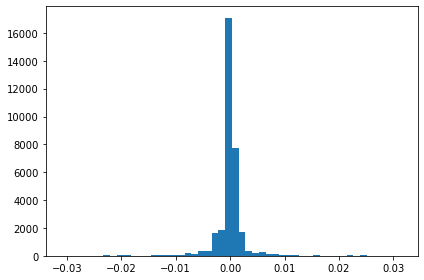

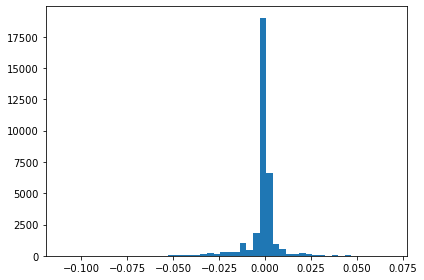

In [11]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(6, 4))

plt.hist(df['isoform_hl_f0_c0_feature_0_ref'].values - df['isoform_hl_f0_c0_feature_0_var'].values, bins=50)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(6, 4))

plt.hist(df['isoform_hl_f8_c0_feature_0_ref'].values - df['isoform_hl_f8_c0_feature_0_var'].values, bins=50)

plt.tight_layout()

plt.show()
